In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score

from pymoo.operators.mutation.bitflip import BitflipMutation, Mutation
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.operators.sampling.rnd import BinaryRandomSampling, Sampling
from pymoo.operators.crossover.hux import HUX
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.indicators.hv import Hypervolume
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import torch

from scipy.stats import ranksums

from joblib import Parallel, delayed
from pathlib import Path
from io import StringIO
import pandas as pd
import numpy as np
import pickle
import os
import re

import matplotlib.pyplot as plt

with open('data.pickle', 'rb') as fh:
	data_mapper = pickle.load(fh)

data_keys = list(data_mapper.keys())

In [8]:
class ClassSensitiveOptimizer(Problem):
	population_size = 100
	n_neighbours = 5
	sequential = False
	def __init__(self, X_train, y_train, X_val, y_val):
		self.mutation_history = {}
		self.generation_number = 0

		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=2,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		
		metrics = []
		for label in np.unique(self.y_train):
			label_idx = np.where(self.y_train==label)

			filtered_x_train = self.X_train[label_idx]
			filtered_y_train = self.y_train[label_idx]

			f_values = []
			for instance in x:
				error = 1
				if np.sum(instance) >= ClassSensitiveOptimizer.n_neighbours:
					model = KNeighborsClassifier(
						n_neighbors=ClassSensitiveOptimizer.n_neighbours
					)
					model.fit(
						filtered_x_train, 
						filtered_y_train
					)

					y_pred = model.predict(self.X_val)
					error = 1 - accuracy_score(self.y_val, y_pred)

				f_values.append(error)
			metrics.append(f_values)

		out["F"] = np.column_stack(metrics)

class DiverseCustomSampling(Sampling):
	def __init__(self):
		super().__init__()

	def _do(self, problem, n_samples, **kwargs):

		target_inclusions = np.random.randint(
			problem.n_var // 3,
			problem.n_var,
			n_samples
		)
		init_pops = []
		for target in target_inclusions:
			array = np.array([1]*target + [0]*(problem.n_var - target))
			np.random.shuffle(array)
			init_pops.append(array)
		init_pops = np.array(init_pops, dtype=np.bool)
		return init_pops

In [9]:
def vae_loss(recon_x, x, mu, logvar):
	recon_loss = nn.MSELoss()(recon_x, x)
	kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
	return recon_loss + kl_div

class CustomDataset(Dataset):
	def __init__(self, x_synthetic, x_true):
		self.x = x_synthetic
		self.y = x_true
	def __len__(self):
		return self.x.shape[0]
	def __getitem__(self, ind):
		x = self.x[ind]
		y = self.y[ind]
		return x, y

In [10]:
data_key = data_keys[0]
x_train = data_mapper[data_key]['x_train'] 
y_train = data_mapper[data_key]['y_train']
x_validation = data_mapper[data_key]['x_validation'] 
y_validation = data_mapper[data_key]['y_validation']
x_test = data_mapper[data_key]['x_test']
y_test = data_mapper[data_key]['y_test']

print(data_key)

0_abalone-20_vs_8-9-10


In [12]:
problem = ClassSensitiveOptimizer(
	x_train,
	y_train,
	x_validation,
	y_validation,
)
algorithm = NSGA2(
	pop_size=ClassSensitiveOptimizer.population_size, 
	sampling=DiverseCustomSampling(),
	crossover=HUX(), 
	mutation=BitflipMutation(), 
	eliminate_duplicates=True,
)
result = minimize(
	problem, 
	algorithm, 
	('n_gen', ClassSensitiveOptimizer.population_size), # <--- maybe increase
	save_history=False
)

# cVAE

In [14]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super(ConditionalVAE, self).__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y):
        # Concatenate input and label
        x = torch.cat([x, y], dim=1)
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # Concatenate latent vector and label
        z = torch.cat([z, y], dim=1)
        h = torch.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar
	

In [16]:
use_x = x_train
use_y = y_train

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_set = CustomDataset(torch.from_numpy(use_x), torch.from_numpy(use_y))
input_dim = use_x[0].shape[0]
batch_size = 20
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

cvae = ConditionalVAE(input_dim, 1, input_dim//2, 2).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

epochs = 200
for epoch in range(epochs):
	cvae.train()
	total_loss = 0
	for batch in train_loader:
		x_batch = batch[0].to(device).float()
		y_batch = batch[1].to(device).float().unsqueeze(1)
		
		recon, mu, logvar = cvae(x_batch, y_batch)
		
		loss = vae_loss(recon, x_batch, mu, logvar)
		
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		total_loss += loss.item()

	print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 8.5652
Epoch 2, Loss: 6.0827
Epoch 3, Loss: 4.6924
Epoch 4, Loss: 3.6771
Epoch 5, Loss: 2.9074
Epoch 6, Loss: 2.3600
Epoch 7, Loss: 1.9754
Epoch 8, Loss: 1.6965
Epoch 9, Loss: 1.5011
Epoch 10, Loss: 1.3462
Epoch 11, Loss: 1.2246
Epoch 12, Loss: 1.1449
Epoch 13, Loss: 1.1059
Epoch 14, Loss: 1.0757
Epoch 15, Loss: 1.0655
Epoch 16, Loss: 1.0582
Epoch 17, Loss: 1.0536
Epoch 18, Loss: 1.0485
Epoch 19, Loss: 1.0470
Epoch 20, Loss: 1.0445
Epoch 21, Loss: 1.0463
Epoch 22, Loss: 1.0446
Epoch 23, Loss: 1.0410
Epoch 24, Loss: 1.0423
Epoch 25, Loss: 1.0417
Epoch 26, Loss: 1.0393
Epoch 27, Loss: 1.0404
Epoch 28, Loss: 1.0389
Epoch 29, Loss: 1.0386
Epoch 30, Loss: 1.0372
Epoch 31, Loss: 1.0388
Epoch 32, Loss: 1.0375
Epoch 33, Loss: 1.0367
Epoch 34, Loss: 1.0366
Epoch 35, Loss: 1.0361
Epoch 36, Loss: 1.0365
Epoch 37, Loss: 1.0360
Epoch 38, Loss: 1.0365
Epoch 39, Loss: 1.0346
Epoch 40, Loss: 1.0344
Epoch 41, Loss: 1.0340
Epoch 42, Loss: 1.0339
Epoch 43, Loss: 1.0328
Epoch 44, Loss: 1.03

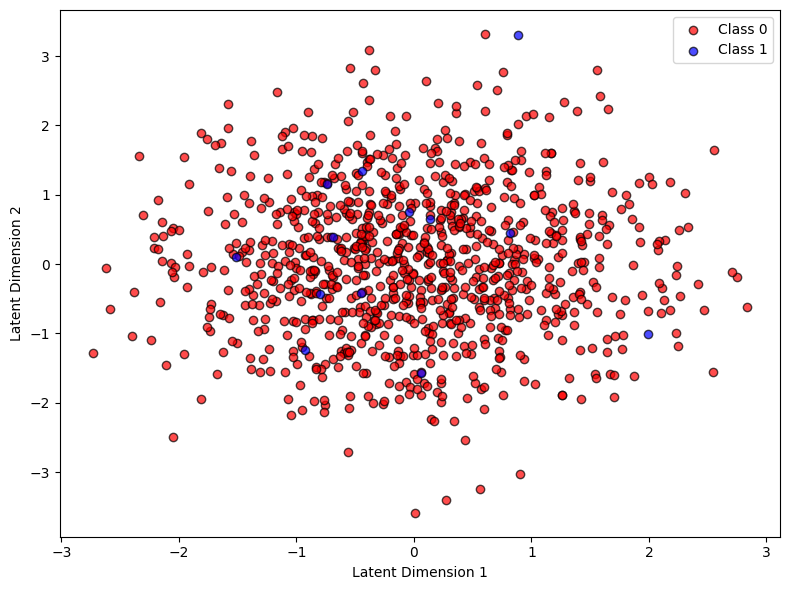

In [17]:
plot_x = x_train
plot_y = y_train

cvae.eval()
with torch.no_grad():    
    x = torch.from_numpy(plot_x).to(device).float()
    y = torch.from_numpy(plot_y).to(device).float().unsqueeze(1)
    mu, logvar = cvae.encode(x, y)
    z = cvae.reparameterize(mu, logvar)

z_np = z.cpu().numpy()

# Define colors for the two classes
colors = ['red', 'blue']
label_names = ['Class 0', 'Class 1']

# Create scatter plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(plot_y)):
    idxs = plot_y == label
    plt.scatter(z_np[idxs, 0], z_np[idxs, 1], c=colors[i], label=label_names[i], alpha=0.7, edgecolors='k')

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()
